In [52]:
# https://www.kaggle.com/code/sohier/optiver-2023-basic-submission-demo/notebook
# 提出はこのapiを使うこと

# '''
# An unlocked version of the timeseries API intended for testing alternate inputs.
# Mirrors the production timeseries API in the crucial respects, but won't be as fast.

# ONLY works afer the first three variables in MockAPI.__init__ are populated.
# '''

# from typing import Sequence, Tuple

# import pandas as pd


# class MockApi:
#     def __init__(self):
#         '''
#         YOU MUST UPDATE THE FIRST THREE LINES of this method.
#         They've been intentionally left in an invalid state.

#         Variables to set:
#             input_paths: a list of two or more paths to the csv files to be served
#             group_id_column: the column that identifies which groups of rows the API should serve.
#                 A call to iter_test serves all rows of all dataframes with the current group ID value.
#             export_group_id_column: if true, the dataframes iter_test serves will include the group_id_column values.
#         '''
#         self.input_paths: Sequence[str] =
#         self.group_id_column: str = 
#         self.export_group_id_column: bool = True
#         # iter_test is only designed to support at least two dataframes, such as test and sample_submission
#         assert len(self.input_paths) >= 2

#         self._status = 'initialized'
#         self.predictions = []

#     def iter_test(self) -> Tuple[pd.DataFrame]:
#         '''
#         Loads all of the dataframes specified in self.input_paths,
#         then yields all rows in those dataframes that equal the current self.group_id_column value.
#         '''
#         if self._status != 'initialized':

#             raise Exception('WARNING: the real API can only iterate over `iter_test()` once.')

#         dataframes = []
#         for pth in self.input_paths:
#             dataframes.append(pd.read_csv(pth, low_memory=False))
#         group_order = dataframes[0][self.group_id_column].drop_duplicates().tolist()
#         dataframes = [df.set_index(self.group_id_column) for df in dataframes]

#         for group_id in group_order:
#             self._status = 'prediction_needed'
#             current_data = []
#             for df in dataframes:
#                 cur_df = df.loc[group_id].copy()
#                 # returning single line dataframes from df.loc requires special handling
#                 if not isinstance(cur_df, pd.DataFrame):
#                     cur_df = pd.DataFrame({a: b for a, b in zip(cur_df.index.values, cur_df.values)}, index=[group_id])
#                     cur_df.index.name = self.group_id_column
#                 cur_df = cur_df.reset_index(drop=not(self.export_group_id_column))
#                 current_data.append(cur_df)
#             yield tuple(current_data)

#             while self._status != 'prediction_received':
#                 print('You must call `predict()` successfully before you can continue with `iter_test()`', flush=True)
#                 yield None

#         with open('submission.csv', 'w') as f_open:
#             pd.concat(self.predictions).to_csv(f_open, index=False)
#         self._status = 'finished'

#     def predict(self, user_predictions: pd.DataFrame):
#         '''
#         Accepts and stores the user's predictions and unlocks iter_test once that is done
#         '''
#         if self._status == 'finished':
#             raise Exception('You have already made predictions for the full test set.')
#         if self._status != 'prediction_needed':
#             raise Exception('You must get the next test sample from `iter_test()` first.')
#         if not isinstance(user_predictions, pd.DataFrame):
#             raise Exception('You must provide a DataFrame.')

#         self.predictions.append(user_predictions)
#         self._status = 'prediction_received'


# def make_env():
#     return MockApi()


In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# %config Completer.use_jedi = False

import os
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import optuna
import optiver2023
import random
from tqdm import tqdm
random.seed(100)

env = optiver2023.make_env()
iter_test = env.iter_test()

REDUCED = True


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

print('python:', sys.version)

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

python: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


In [54]:
train = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
test = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv')
sample_submission = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv')
revealed_targets = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv')

In [55]:
train.head(5)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [56]:
revealed_targets.head(5)

,stock_id,date_id,seconds_in_bucket,time_id,revealed_target,revealed_date_id,revealed_time_id
0,0.0,478,0,26290,-2.310276,477.0,26235.0
1,1.0,478,0,26290,-12.850165,477.0,26235.0
2,2.0,478,0,26290,-0.439882,477.0,26235.0
3,3.0,478,0,26290,7.259846,477.0,26235.0
4,4.0,478,0,26290,4.780292,477.0,26235.0


In [57]:
# distribution except for stock_id, date_id, seconds_in_bucket, row_id
# fig = plt.figure()
# ax = fig.add_subplot(1,1,1)
train = train.drop(['stock_id','row_id','seconds_in_bucket','row_id', 'far_price', 'near_price'], axis=1)
# boxplot_labels = plt_train.columns
# sns.boxplot(train['imbalance_size'])

In [58]:
# 欠損値がどのくらいあるか見てみる
# 今回のデータは幅が広そうなので中央値でnull埋め
# すべて量的データ

null_data = train.isnull()

print('data size:', len(train))
print('null sum', null_data.sum())
print('===============================')

if REDUCED: train = train[:1000] # データ量が多すぎるのでいったん1000件くらいで

data size: 5237980
null sum date_id                      0
imbalance_size             220
imbalance_buy_sell_flag      0
reference_price            220
matched_size               220
bid_price                  220
bid_size                     0
ask_price                  220
ask_size                     0
wap                        220
target                      88
time_id                      0
dtype: int64


In [59]:
fillna_train = pd.DataFrame()
col_names = train.columns
for col_name in col_names:
    fillna_train[col_name] = train[col_name].fillna(train[col_name].median()) #いったん中央値で試す

print(fillna_train.isnull().sum())
print('columns length ->', len(col_names))

date_id                    0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
dtype: int64
columns length -> 12


In [66]:
# params
params = {
    'lgbm_params':{
        'objective': 'regression',
        'metrics': 'mae',
        'n_estimaters': 500,
        'random_state': 100,
        'learning_rate': 0.01,
        'device': 'gpu'
    },
    'nn_params':{
        'input_dim': len(col_names),
        'embed_dim': len(col_names)*2,
        'num_heads': len(col_names),
        'output_dim': 1,
        'learning_rate': 0.01
    }
}

In [67]:
# モデル、学習用関数の定義

EPOCHS = 10
BATCH_SIZE = 32
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

class Dataset:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# NNとLightGBMは分離させる
class NeuralNetEnsembleModel(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.nn_params = params['nn_params']

        # layer
        self.input_layer = nn.Linear(self.nn_params['input_dim'], self.nn_params['embed_dim'])
        self.attn_layer = nn.MultiheadAttention(embed_dim=self.nn_params['embed_dim'], num_heads=self.nn_params['num_heads'], batch_first=True)
        self.output_layer = nn.Softmax(dim=self.nn_params['output_dim'])
    
    def forward(self, X):      
        y = self.input_layer(X)
        y = self.attn_layer(y)
        y = self.output_layer(y)
        return y
                 
        # resnetを入れる？

# NNの学習
def train(model, dataloader, optimizer, loss_fn, device):
    model.train() #学習モード
    train_loss = 0

    for batch_X, batch_y in tqdm(dataloader): # ミニバッチ学習
        batch_X, batch_y = batch_X.to(device), batch_y.to(device) # gpuに送る
        optimzer.zero_grad()
        pred = model.forward(batch_X)
        loss = loss_fn(pred, batch_y)
        loss.backward()
        optimizer.step() # ネットワーク更新
        train_loss += loss.item()

    return train_loss / len(dataloader)

def eval(model, dataloader, optimizer, loss_fn, device):
    model.eval() #評価モード
    eval_loss = 0
    
    for batch_X, batch_y in tqdm(dataloader):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device) # gpuに送る
        pred = model.forward(batch_X)
        loss = loss_fn(pred, batch_y)
        eval_loss += loss
    return eval_loss / len(dataloader)
    


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

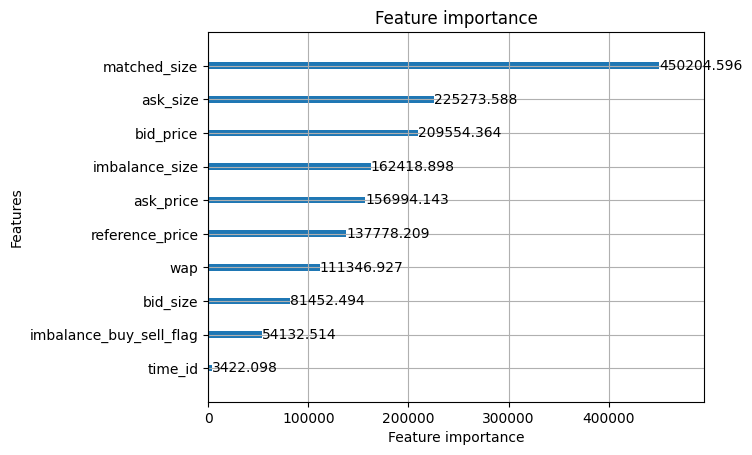

In [71]:
# LightGBM学習実行

train_X = fillna_train.drop('target', axis=1)
train_y = fillna_train['target']

# NNに突っ込むためにはテーブルデータをベクトルに変換

lgbm_model = lgbm.LGBMRegressor(**params['lgbm_params'])
lgbm_model.fit(train_X, train_y)
lgbm.plot_importance(lgbm_model, importance_type="gain")


In [ ]:
model = NeuralNetEnsembleModel(params=params).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.L1Loss()

train_dataset = Dataset(train_X, train_y)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
# eval_dataset
# eval_dataloader

# for epoch in range(EPOCHS):
#     train_loss = train(model=model, dataloader=train_dataloader, optimizer=optimizer, loss_fn=loss_fn, device=device)
    
    
#     eval_loss = eval(model=model, dataloader=eval_dataloader, optimizer=optimizer, loss_fn=loss_fn, device=device)